In [1]:
# pip install --upgrade xarray seaborn pandas numpy

In [2]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns

1. Extracting XArray data into Tidy Pandas DataFrames
  - Multiple columns
2. Plotting Subsets of your data using Logical Indexing
  - `sns.relplot(data=, x=, y=, estimator=, errorbar=, col=, col_wrap=, kind='line')`
3. Making and Displaying Pivot Tables (`df.groupby().agg().unstack()`), (`df.pivot_table(index='col1', columns='col2', values='col3', agg='mean')`
  - `sns.heatmap`
    - 'annot=' and 'fmt=
    - normalize along different axes?
  - `style.background_gradient()`

### Download the dataset

In [3]:
from pathlib import Path
import requests
from tqdm import tqdm

def download_from_sciebo(public_url, to_filename, is_file=True):
    """
    Downloads a file or folder from a shared URL on Sciebo.
    """
    # Create the folder if a longer path was described
    path = Path(to_filename)
    if len(path.parts) > 1:
        Path(to_filename).parent.mkdir(parents=True, exist_ok=True)

    r = requests.get(public_url + "/download", stream=True)

    if 'Content-Length' in r.headers and is_file:
        total_size = int(r.headers['Content-Length'])
        progress_bar = tqdm(desc=f"Downloading {to_filename}", unit='B', unit_scale=True, total=total_size)
    else:
        progress_bar = None

    with open(to_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
            if progress_bar:
                progress_bar.update(len(chunk))

    if progress_bar:
        progress_bar.close()

download_from_sciebo('https://uni-bonn.sciebo.de/s/JFeueaaWCTVhTZh', 'data/steinmetz_2016-12-14_Cori.nc')

# ERP Analysis With Pandas And Seaborn

---

## Overview

We will continue to use [Steinmetz et al, 2019 in Nature](https://www.nature.com/articles/s41586-019-1787-x) dataset. The experiment involved a mouse being presented with two gradients of varying intensities. The mouse's task was to adjust a wheel to center the brighter gradient on the screen. Simultaneously, Local Field Potential (LFP) measurements were recorded across various brain areas. These measurements were taken 250 times in 2.5 seconds, with data collected at 0.01-second intervals. 


**Analysis goals**

In these exercises, our primary objective is to analyze and visualize Local Field Potential (LFP) data collected from distinct brain regions separately. Through this analysis, we aim to:
  - compute trial statistics on LFP amplitudes (e.g. mean, min, max)
  - compare these statistics between different brain areas
  

**Learning goals**

In this notebook, we'll focus on learning Seaborn's:
  - `sns.catplot()` funciton for categorical plots
  - `sns.lineplot()` function for plotting time series models
  - `sns.relplot()` for making faceted rows and columns of data of figures effectively using relplot and
  - `sns.heatmap()` for using colors to compare trends.

---
## Extracting Data from XArray Datasets into Tidy DataFrames
### Load Dataset

In this section, we'll work with a dataset from a single session recording of Cori the mouse ('steinmetz_2016-12-14_Cori.nc'). 

Our primary objective is to read this data and convert it into a Pandas dataframe, which will serve as the foundation for the subsequent exercises.

**Load dataset and convert to Pandas dataframe:**

| Method/Code                                             | Description                                                                   |
|--------------------------------------------------------|-------------------------------------------------------------------------------|
| `dset = xr.load_dataset("path/to/file/like/this.nc")` | Loads the dataset from the specified file path using xarray (`xr`).      |
| `df = dset['column1'].to_dataframe()`                    | Extracts the 'column1' data variable from the dataset and converts it into a Pandas DataFrame (`df`). |
| `df.reset_index()`                                   | Resets the index of the 'df' DataFrame to create a default integer index.   |
| `dset['column1'].to_dataframe().reset_index()` | All of it, together! |
| `dset[['column1', 'column2']].to_dataframe().reset_index()` | Extracts column1 and column2, converts to dataframe, and resets index |
| `df.catplot(data=df, x='categorical_column_1', y='continuous_column', kind='bar'/'count'/'box'), col='categorical_column_2` | Makes categorical plots of specified kind split into columns based on categories in categorical_column_2 |

**Exercises**

Make a variable called `dset` by calling by Xarray's `xr.load_dataset()` function on the 'steinmetz_2016-12-14_Cori.nc' session file.  Confirm that the "lfp" data variable is there.

In [4]:
dset = xr.load_dataset('data/steinmetz_2016-12-14_Cori.nc')
dset

<xarray.Dataset>
Dimensions:             (trial: 364, time: 250, cell: 734,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 7, spike_id: 2446173)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 359 360 361 362 363 364
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 729 730 731 732 733 734
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'ACA' 'LS' ... 'SUB' 'VISp'
  * spike_id            (spike_id) int32 1 2 3 4 ... 2446171 2446172 2446173
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 100 0 100 0 50 0 0 ... 0 100 50 50 0 25 100
    contrast_right      (trial) int8 0 50 50 0 100 0 0 ... 25 100 25 25 50 0 100
    gocue               (trial) float64 1.027 0.8744 0.8252 ... nan nan nan
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 1.0 1.0 1.0 -1.0 ... nan nan nan nan
    feedback_time       (trial) float64 1.187 1.438 0.986 2.296 ... nan nan nan
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... -0...
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... 0.0
    lfp                 (brain_area_lfp, trial, time) float64 -2.851 ... 5.571
    spike_time          (spike_id) float32 0.2676 2.308 0.8535 ... 2.189 2.399
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 734 734 734 734 734
    spike_trial         (spike_id) uint32 21 21 31 37 43 ... 364 364 364 364 364
Attributes:
    session_date:  2016-12-14
    mouse:         Cori
    stim_onset:    0.5
    bin_size:      0.01

**Example** Make a catplot for feedback_type counting number of values in each category

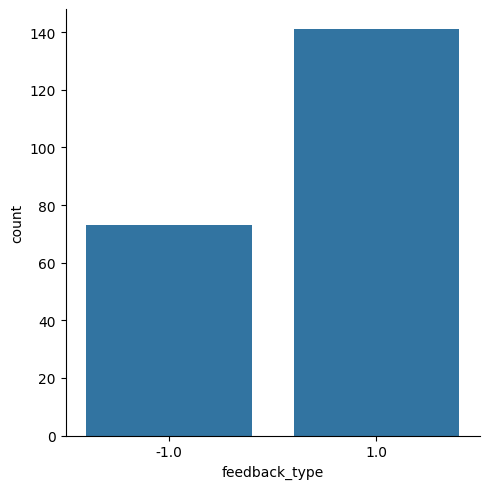

In [5]:
df = dset['feedback_type'].to_dataframe().reset_index()
sns.catplot(data=df, x='feedback_type', kind='count')

Make a catplot for response_type counting number of values in each category

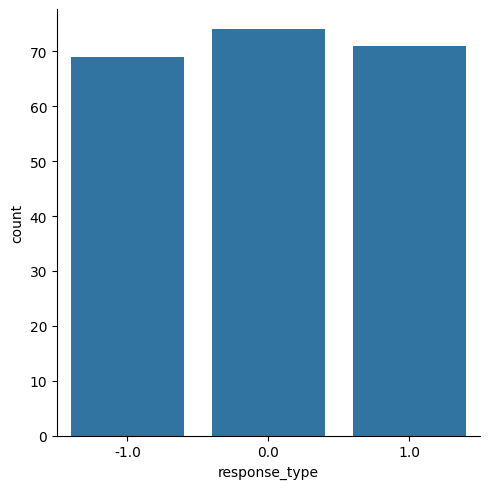

In [6]:
df = dset['response_type'].to_dataframe().reset_index()
sns.catplot(data=df, x='response_type', kind='count')

Make a catplot for brain_area counting number of values in each category

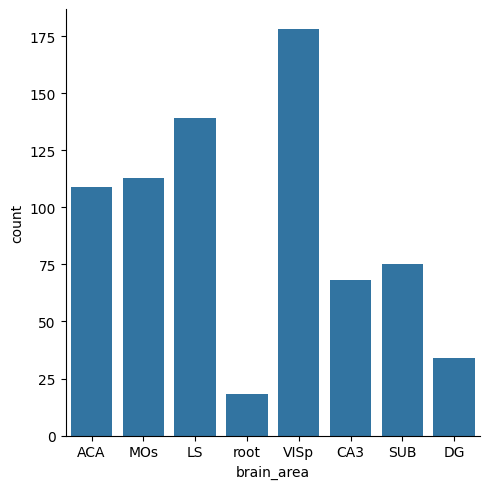

In [7]:
df = dset['brain_area'].to_dataframe().reset_index()
sns.catplot(data=df, x='brain_area', kind='count')

**Example** Make a bar plot visualizing how mean reaction time varies for different feedback types

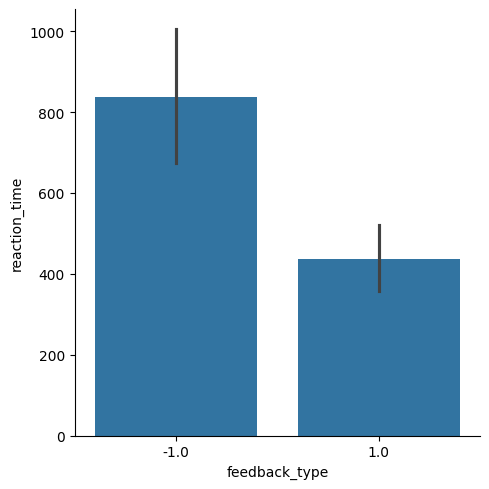

In [8]:
df = dset[['feedback_type', 'reaction_time']].to_dataframe().reset_index()
sns.catplot(data=df, x='feedback_type', y='reaction_time', kind='bar')

Make a bar plot visualizing how mean response time varies for different feedback types

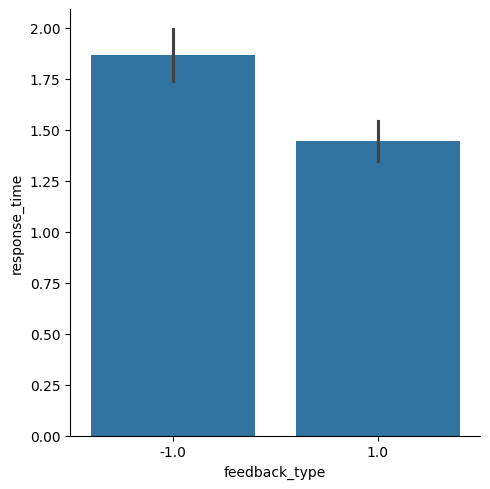

In [9]:
df = dset[['feedback_type', 'response_time']].to_dataframe().reset_index()
sns.catplot(data=df, x='feedback_type', y='response_time', kind='bar')

Make a bar plot visualizing how mean response time varies for different response types

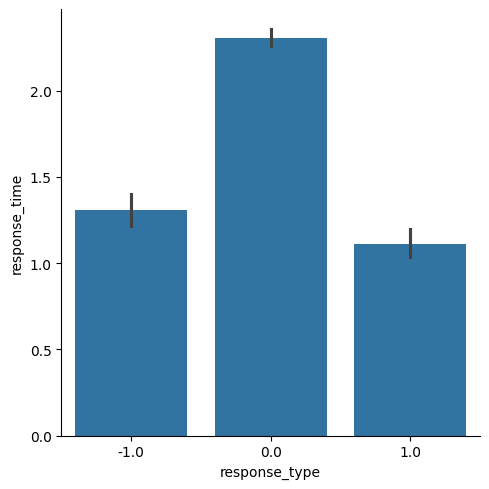

In [10]:
df = dset[['response_type', 'response_time']].to_dataframe().reset_index()
sns.catplot(data=df, x='response_type', y='response_time', kind='bar')

Make a box plot visualizing how mean response time varies for different response types

Hint: Use kind='box'

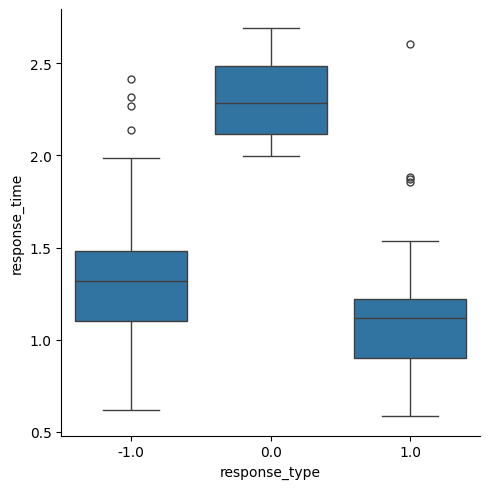

In [11]:
df = dset[['response_type', 'response_time']].to_dataframe().reset_index()
sns.catplot(data=df, x='response_type', y='response_time', kind='box')

Make a box plot visualizing how mean feedback time varies for different feedback types

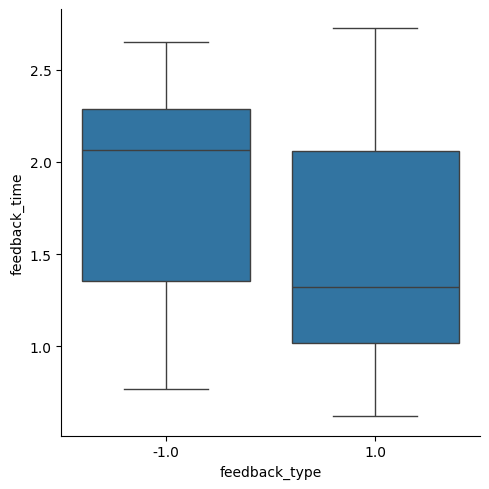

In [12]:
df = dset[['feedback_type', 'feedback_time']].to_dataframe().reset_index()
sns.catplot(data=df, x='feedback_type', y='feedback_time', kind='box')

**Example** Make a box plot visualizing how mean feedback time varies for different feedback types in different columns

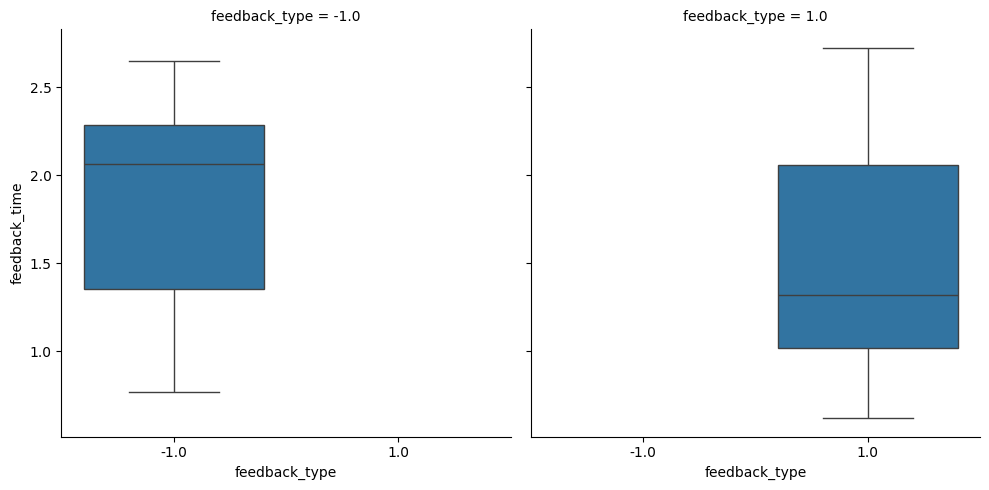

In [13]:
df = dset[['feedback_type', 'feedback_time']].to_dataframe().reset_index()
sns.catplot(data=df, x='feedback_type', y='feedback_time', kind='box', col='feedback_type')

Make a box plot visualizing how mean response time varies for different feedback types in different columns

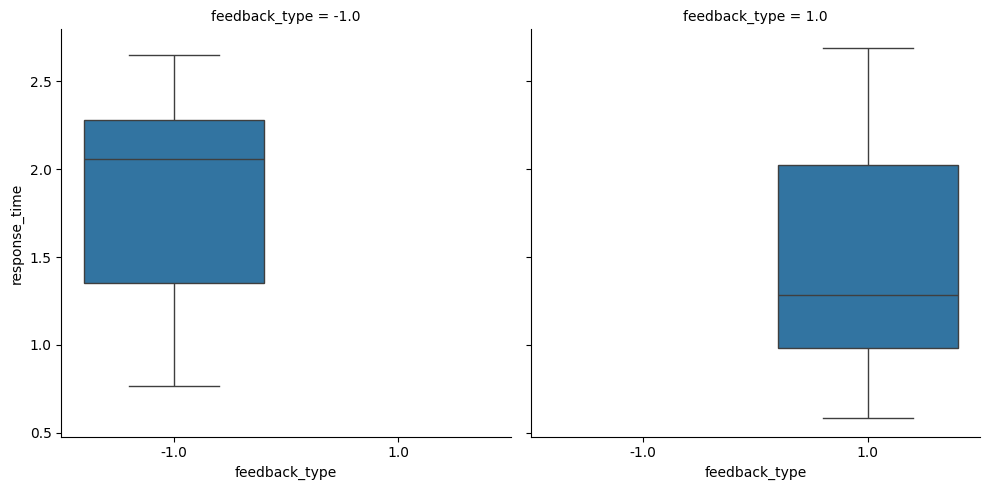

In [14]:
df = dset[['feedback_type', 'response_time']].to_dataframe().reset_index()
sns.catplot(data=df, x='feedback_type', y='response_time', kind='box', col='feedback_type')

 Make a box plot visualizing how mean feedback time varies for different feedback types  separated into columns based on response types

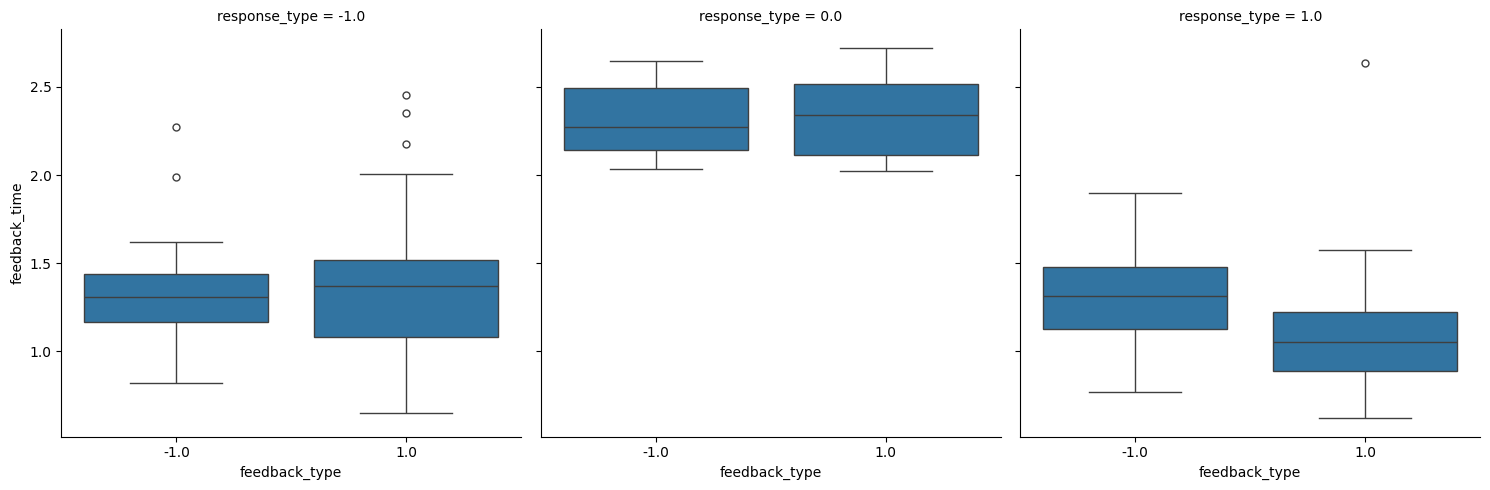

In [15]:
df = dset[['feedback_type', 'feedback_time', 'response_type']].to_dataframe().reset_index()
sns.catplot(data=df, x='feedback_type', y='feedback_time', kind='box', col='response_type')

 Let's plot this another way. Make a box plot visualizing how mean feedback time varies for different response types separated into columns based on feedback types

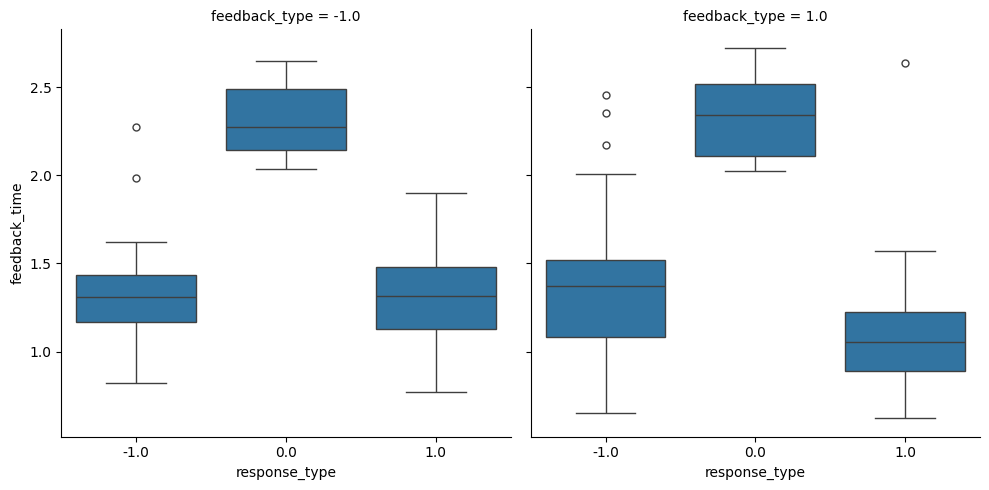

In [16]:
df = dset[['feedback_type', 'feedback_time', 'response_type']].to_dataframe().reset_index()
sns.catplot(data=df, x='response_type', y='feedback_time', kind='box', col='feedback_type')

Make a box plot visualizing how mean lfp varies for different brain areas separated into columns based on feedback types

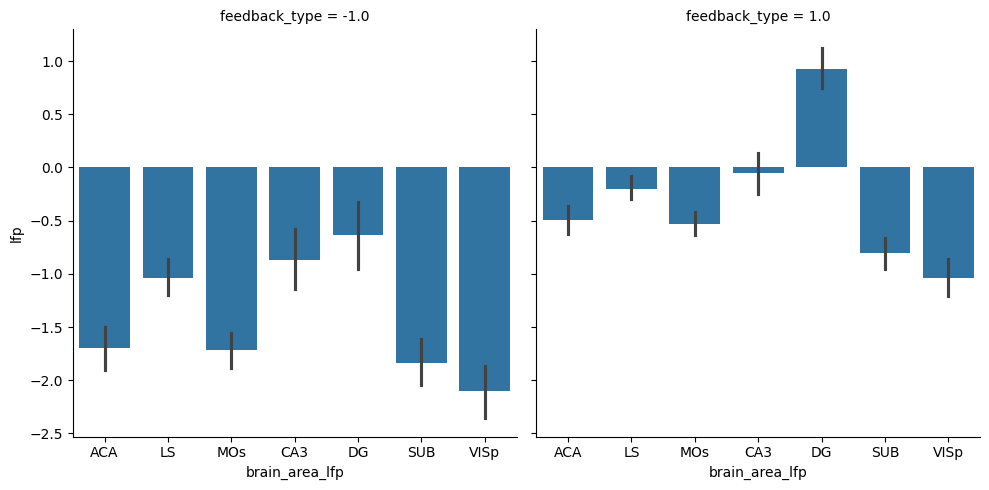

In [17]:
df = dset[['lfp', 'feedback_type']].to_dataframe().reset_index()
sns.catplot(data=df, x='brain_area_lfp', y='lfp', kind='bar', col='feedback_type')

Make a box plot visualizing how mean lfp varies for different brain areas separated into columns based on response types

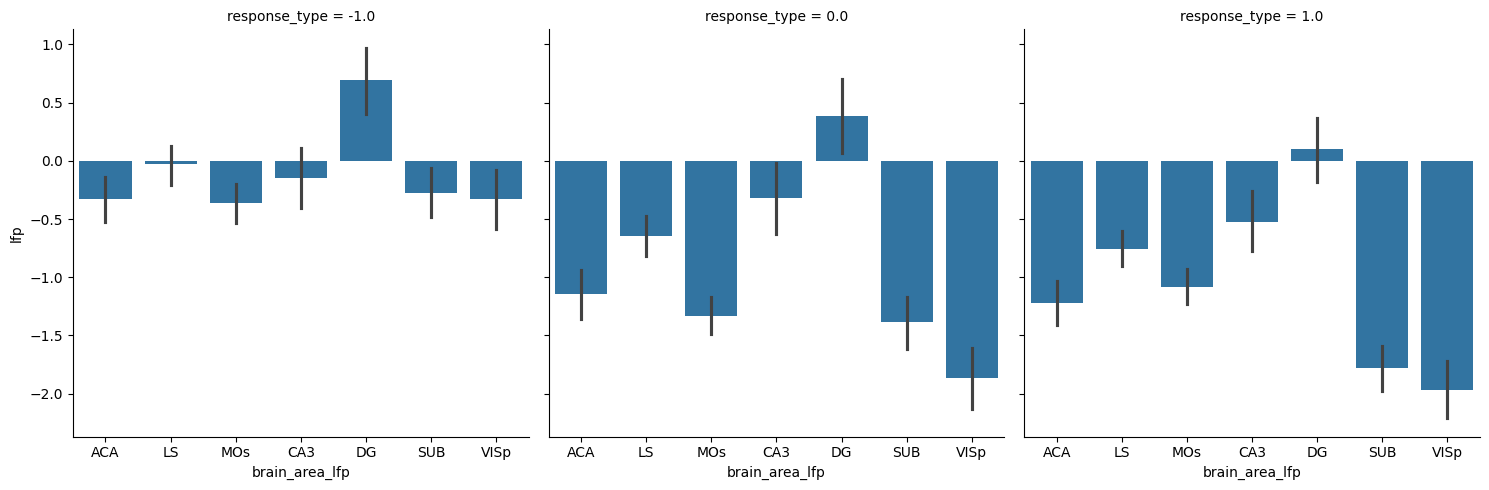

In [18]:
df = dset[['lfp', 'response_type']].to_dataframe().reset_index()
sns.catplot(data=df, x='brain_area_lfp', y='lfp', kind='bar', col='response_type')

## Explore and Visualize LFP Data for VISp Area

### Selecting Data based on its Values ("Logical Indexing" or "Masking") and Plotting it in MultiFaceted Line Plots with `sns.relplot()`

##### Selecting Data based on its Values ("Logical Indexing" or "Masking") and Plotting it in MultiFaceted Line Plots with `sns.relplot()`

| Code                       | Description                                                         |
|----------------------------------------|---------------------------------------------------------------------|
| `mask = df["col_1"] == 'val_1'`     | Store which values of `col_1` are equal to `'val_'` |
| `mask = mask1 & mask2` | Store which values are true for both `mask1` and `mask2` |
| `mask = mask1 \| mask2` | Store which values are true for at least one of `mask1` or `mask2` |
| `df[mask]` | Get only the rows of `df` for which the values in `mask` are `True`.  |


##### Plotting MultiFaceted Line Plots with Seaborn: `sns.relplot()`

| Code       | Description                                                         |
|-------------------|---------------------------------------------------------------------|
| `sns.relplot()` | Creates a relational plot using Seaborn. Specifies the following parameters:
| | `data`: DataFrame variable that the plot will be made from.
| | `x=`: Column to use for the x-axis of the plot.
| | `y=`: Column to use for the y-axis of the plot.
| | `kind=`: "line" for a line plot, "scatter" for a scatter plot.
| | `col=`: Column to use to split the figure into columns
| | `col_wrap=`: The max number of columns per row 
| | `n_boot=`: Number of bootstrap resampling to compute confidence intervals.

**Example** Make a line plot of `time` vs `lfp`, but only for trial numbers less than 50.

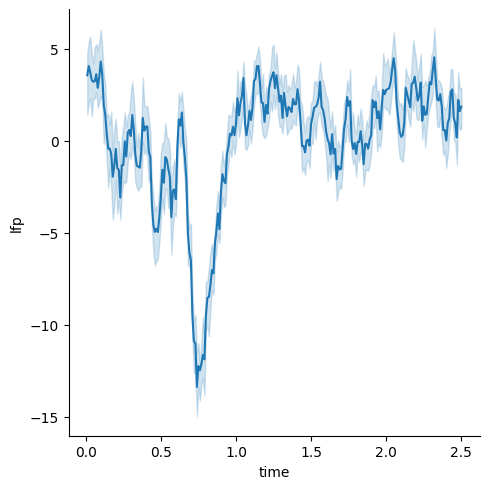

In [19]:
df = dset[['lfp']].to_dataframe().reset_index()
mask = df['trial'] < 50
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Make a line plot of `time` vs `lfp`, but only for for trials where `contrast_left` was `100`

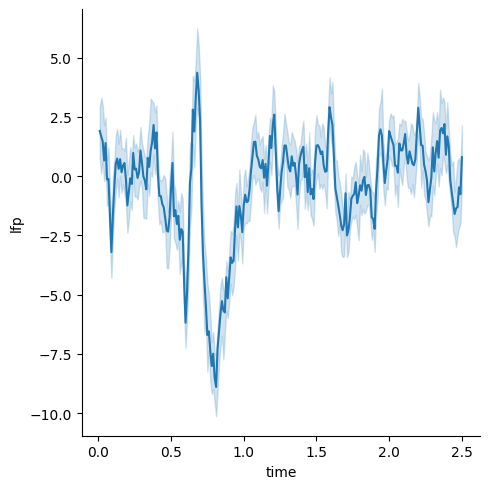

In [20]:
df = dset[['lfp', 'contrast_left']].to_dataframe().reset_index()
mask = df['contrast_left'] == 100
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

There seems to be a strong response right after t=0.5.  This is when the visual stimulus appeared in each trial.  Let's see if the response is still there when no stimulus was presented: 

Make a line plot of `time` vs `lfp`, but only for for trials where `contrast_left` was `0` and `contrast_right` was `0`

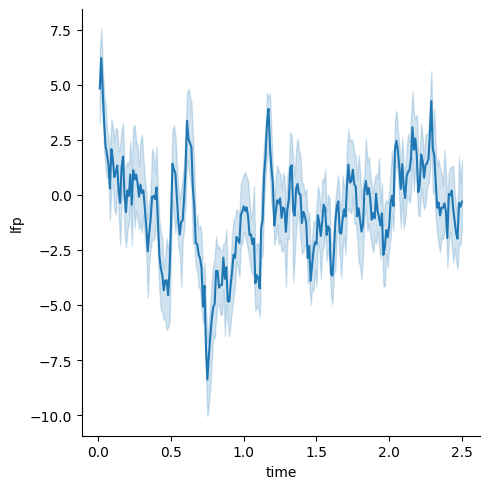

In [21]:
df = dset[['lfp', 'contrast_left', 'contrast_right']].to_dataframe().reset_index()
mask1 = df['contrast_left'] == 0
mask2 = df['contrast_right'] == 0
mask = mask1 & mask2
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Make a line plot of `time` vs `lfp`, but only for for trials where either `contrast_left` was greator `50` **or** `contrast_right` was greater than `50`

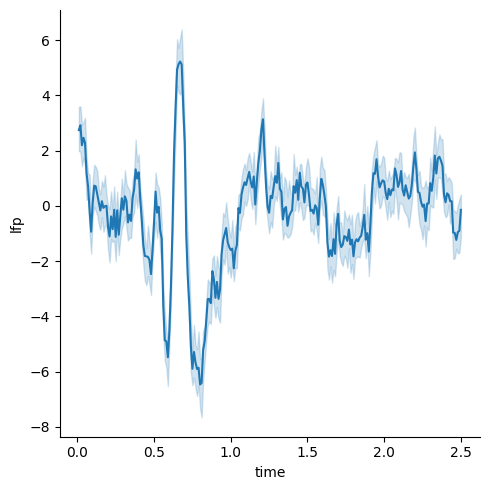

In [22]:
df = dset[['lfp', 'contrast_left', 'contrast_right']].to_dataframe().reset_index()
mask1 = df['contrast_left'] > 50
mask2 = df['contrast_right'] > 50
mask = mask1 | mask2
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Make a line plot of `time` vs `lfp`, but only for `brain_area_lfp` measurements in the visual cortex area `'VISp'`.

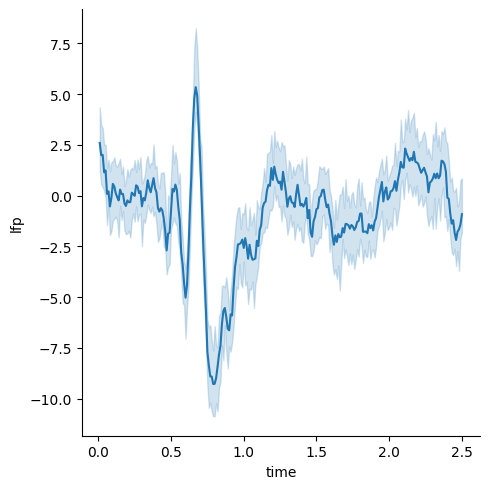

In [23]:
df = dset[['lfp', 'brain_area_lfp']].to_dataframe().reset_index()
mask = df['brain_area_lfp'] == 'VISp'
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

Does the hippocampus have such a distinct response?  Make a line plot of `time` vs `lfp`, but only for `brain_area_lfp` measurements in either `'DG'` or `'CA3'`.

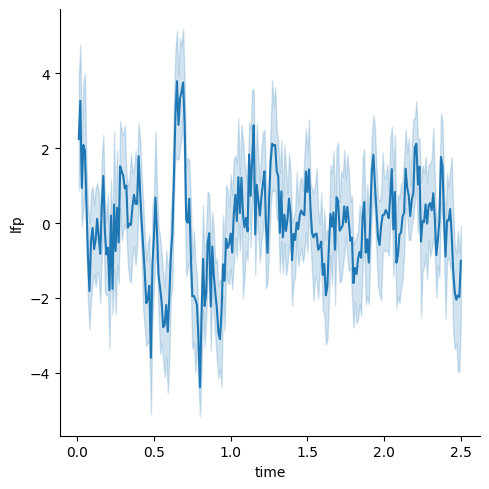

In [24]:
df = dset[['lfp', 'brain_area_lfp']].to_dataframe().reset_index()
mask1 = df['brain_area_lfp'] == 'DG'
mask2 = df['brain_area_lfp'] == 'CA3'
mask = mask1 | mask2
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', n_boot=20);

How does the mouse's response affect the lfp in the visual cortex?  Make a line plot of `time` vs `lfp`, but only for `brain_area_lfp` measurements in the visual cortex area `'VISp'`, and use `hue` to compare the lfp between different `response_type` values.

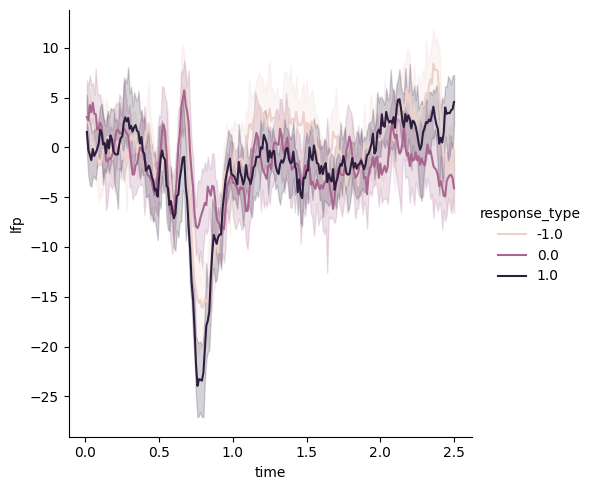

In [25]:
df = dset[['lfp', 'brain_area_lfp', 'response_type']].to_dataframe().reset_index()
mask = df['brain_area_lfp'] == 'VISp'
sns.relplot(data=df[mask], x='time', y='lfp', kind='line', hue='response_type', n_boot=20);

There are so many different brain areas; let's plot them all at once in different subplots.  Make a line plot of `time` vs `lfp`, where `col` is the brain area.  (if there are too many columns, you can set `col_wrap=3` to make new rows automatically).

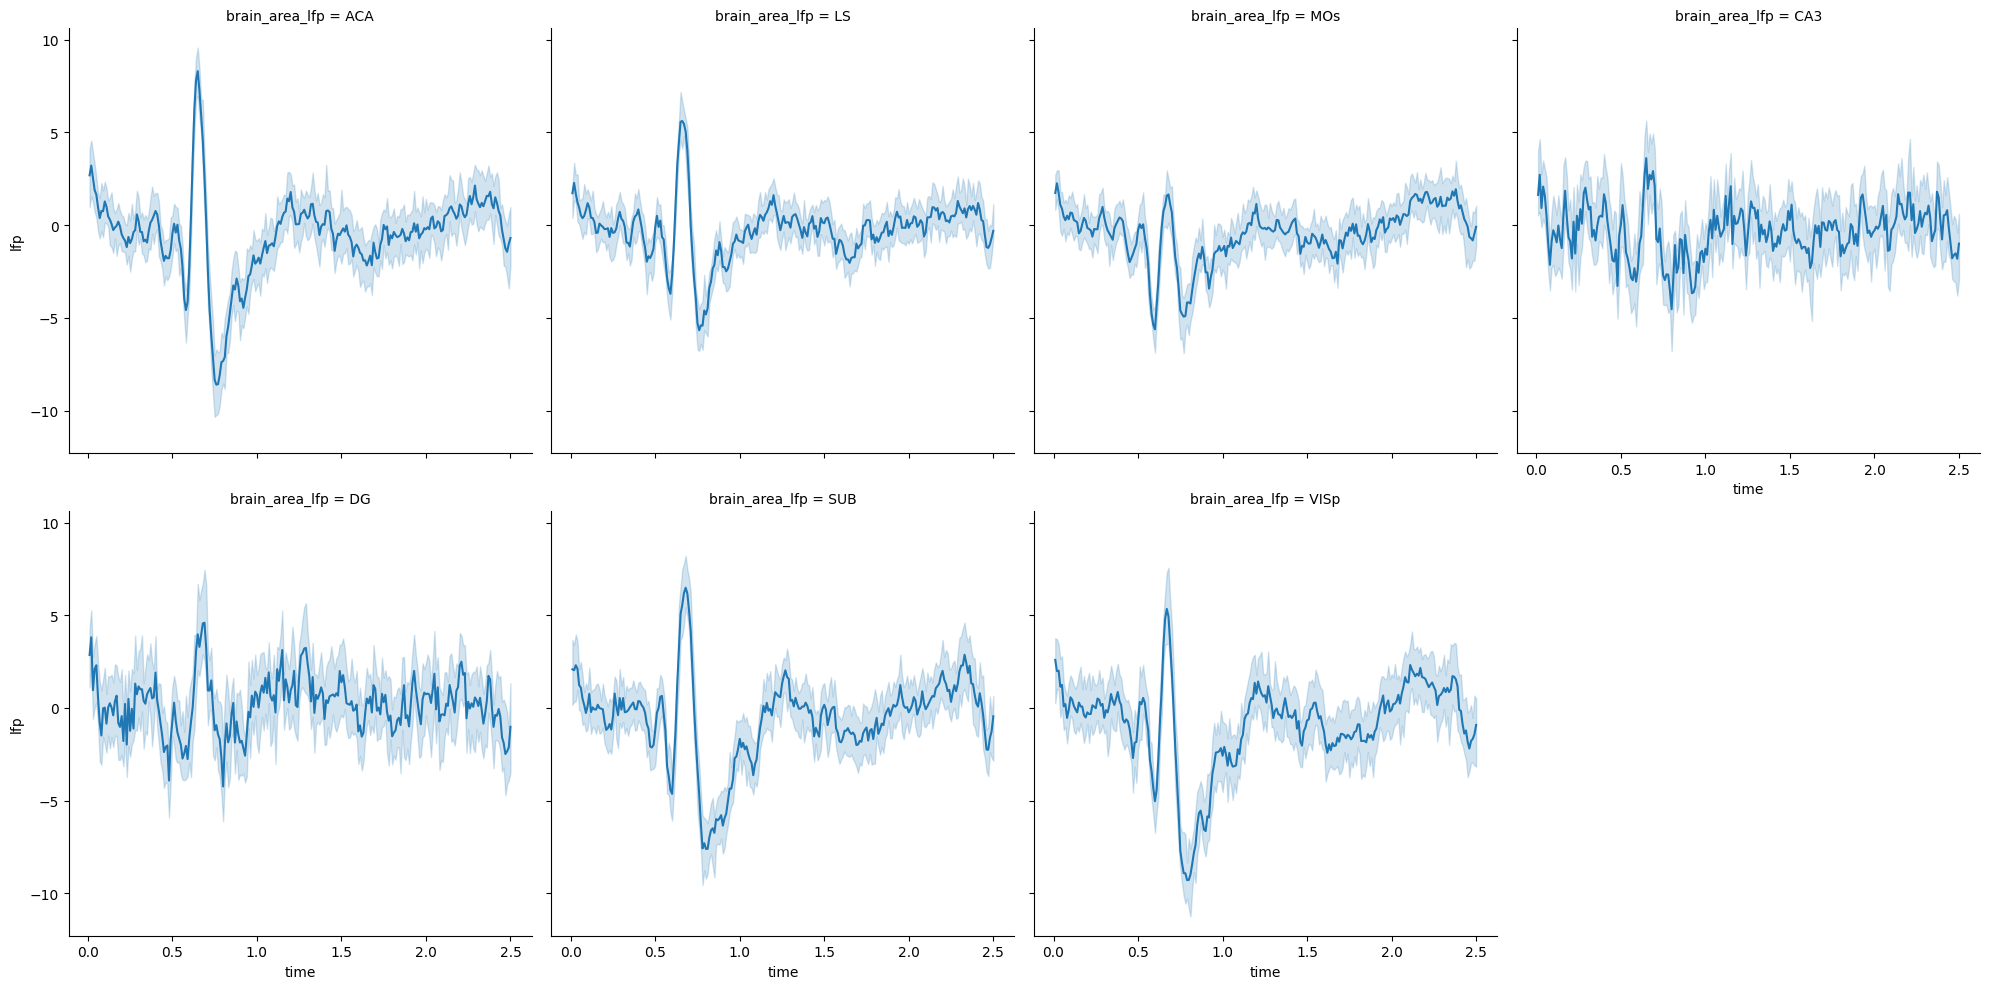

In [26]:
df = dset[['lfp', 'brain_area_lfp']].to_dataframe().reset_index()
sns.relplot(data=df, x='time', y='lfp', kind='line', col='brain_area_lfp', col_wrap=4, n_boot=20);

For each brain area, compare the lfps to different response types.  Which brain areas seem most related to the subject's behavior?

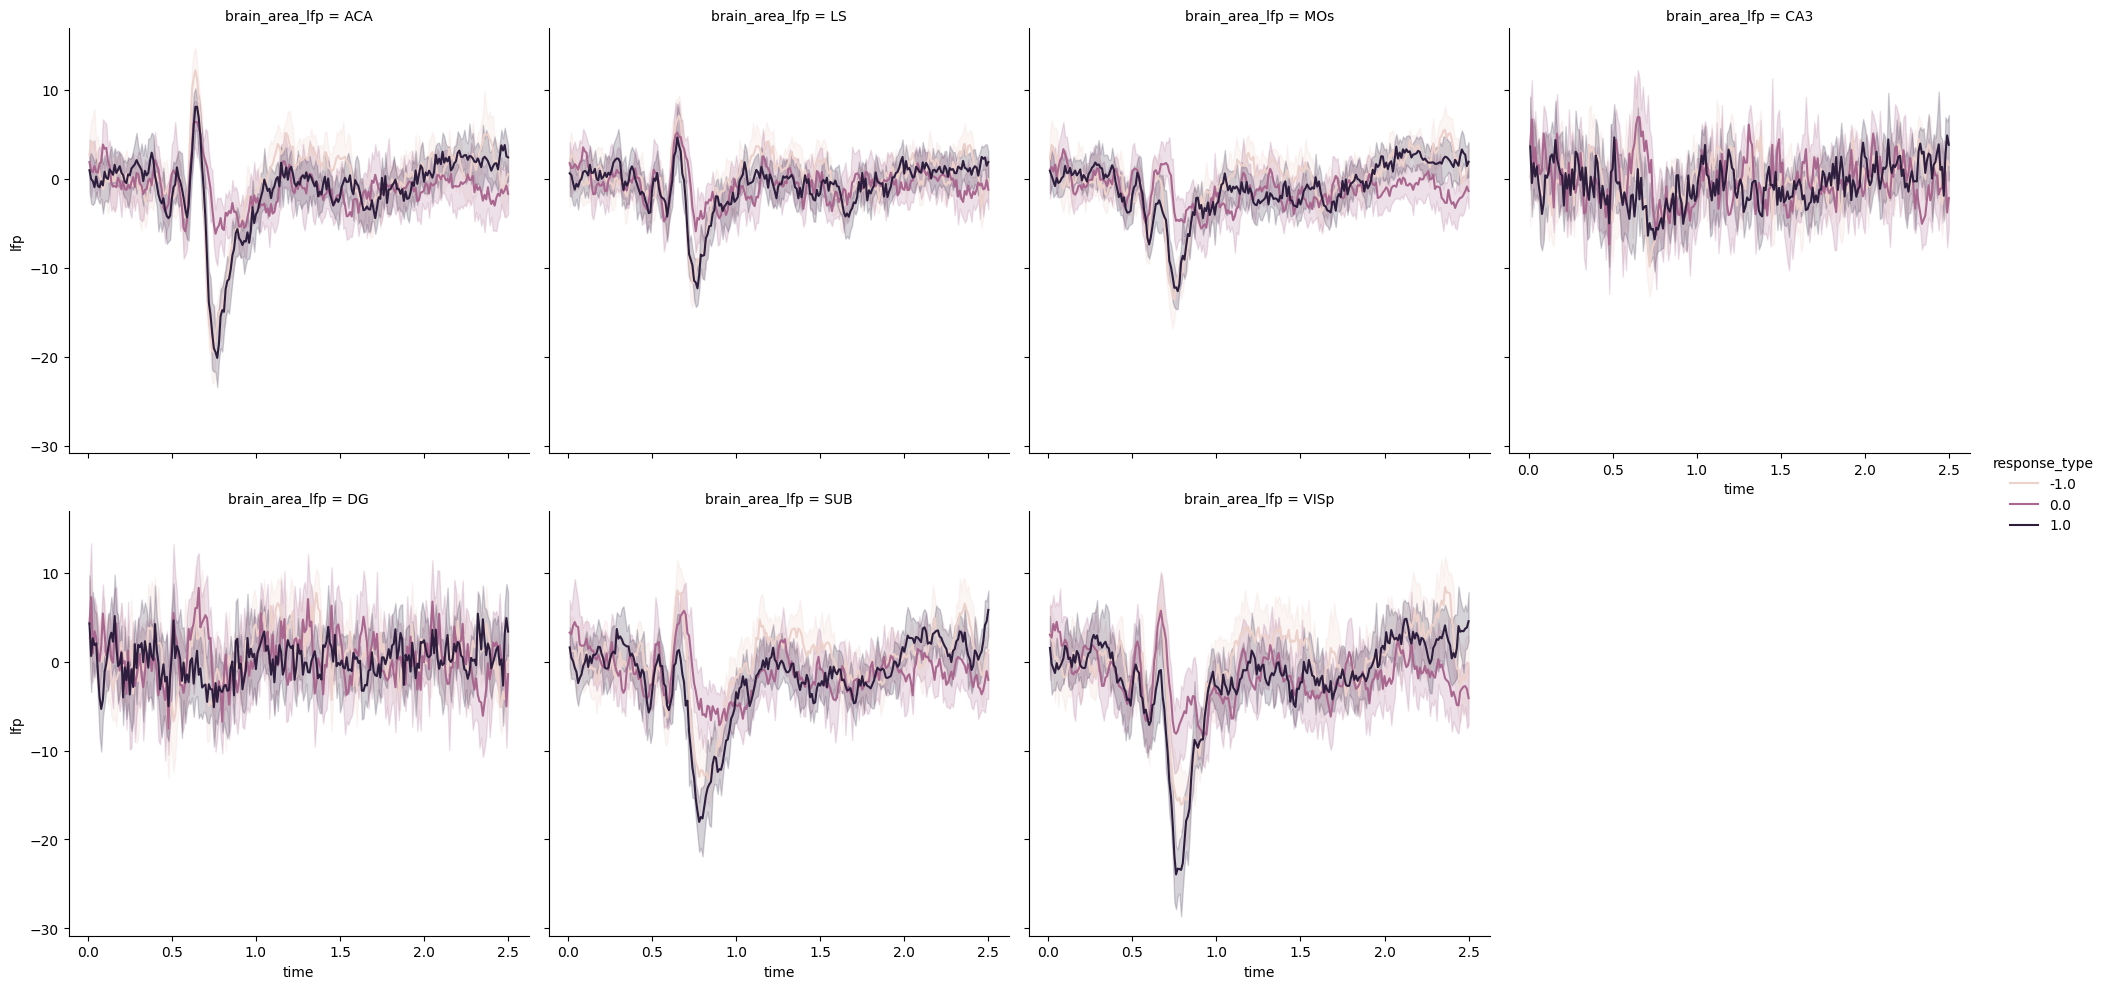

In [27]:
df = dset[['lfp', 'brain_area_lfp', 'response_type']].to_dataframe().reset_index()
sns.relplot(data=df, x='time', y='lfp', kind='line', col='brain_area_lfp', hue='response_type', col_wrap=4, n_boot=20);

## Visualizing Average LFP Data with Heatmap

Let's try to visualize same information for all brain area in a different format. Sometimes, it might be enough to only see variations in terms of color change rather than number. This case, heatmap could be very informative to identify patterns in the time series of mean LFP signal across all trials.

We will make use of group-by method of Pandas dataframe to aggregate LFP and Seaborn heatmap method to visualize

| Method | Description |
| --- | --- |
| `mask = df["col_1"] == 'val_1'` | Store which values of `col_1` are equal to `'val_1'`. |
| `mask = mask1 & mask2` | Store which values are true for both `mask1` and `mask2`. |
| `mask = mask1 \| mask2` | Store which values are true for at least one of `mask1` or `mask2`. |
| `df[mask]` | Get only the rows of `df` for which the values in `mask` are `True`. |
| `df.groupby(['column1','column2'])['column3'].mean().unstack()` | Aggregate `column3` with respect to `column1` and `column2` and unstack the table. |
| `df.pivot_table(index='column1', columns='column2', values='column3', aggfunc='mean')` | Does the same as above. |
|`sns.heatmap(grouped_df)`| Create heatmap of grouped_df |

**Example** Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time'.

<Axes: xlabel='time', ylabel='brain_area_lfp'>

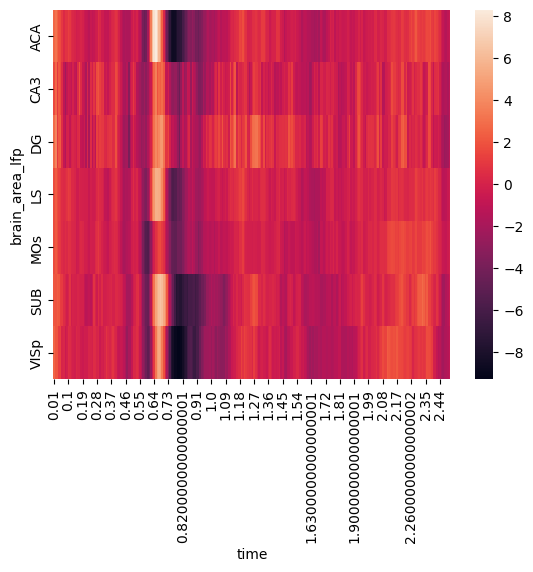

In [28]:
df = dset['lfp'].to_dataframe().reset_index()
group = df.groupby(['brain_area_lfp', 'time'])['lfp'].mean().unstack()
sns.heatmap(group)

Make a heatmap visualization of the median Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time'

<Axes: xlabel='time', ylabel='brain_area_lfp'>

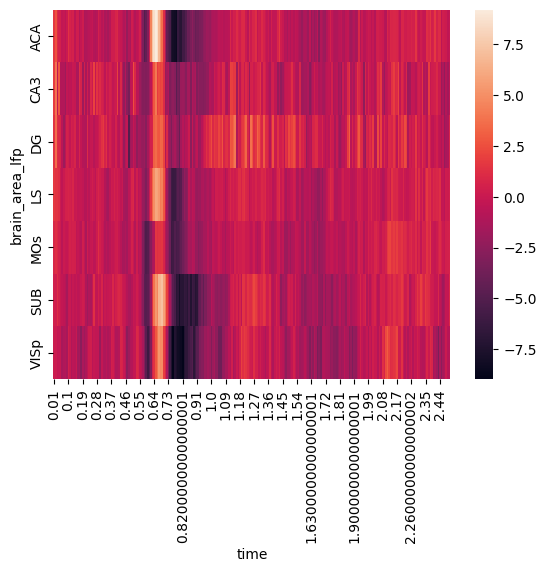

In [29]:
df = dset['lfp'].to_dataframe().reset_index()
group = df.groupby(['brain_area_lfp', 'time'])['lfp'].median().unstack()
sns.heatmap(group)

Make a heatmap visualization of the maximum Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time'

<Axes: xlabel='time', ylabel='brain_area_lfp'>

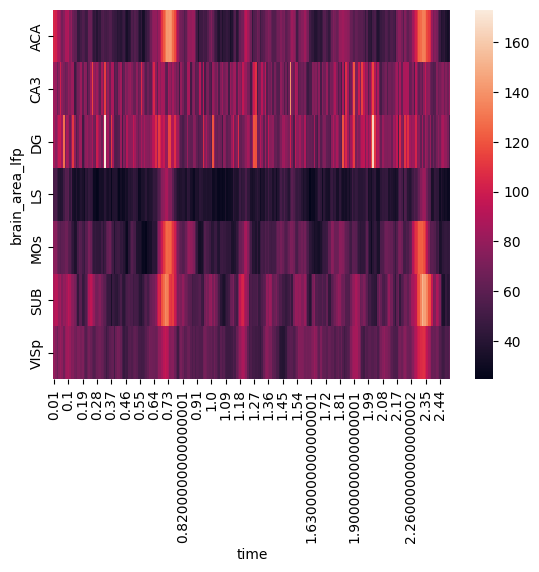

In [30]:
df = dset['lfp'].to_dataframe().reset_index()
group = df.groupby(['brain_area_lfp', 'time'])['lfp'].max().unstack()
sns.heatmap(group)

Make a heatmap visualization of the minimum Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time'

<Axes: xlabel='time', ylabel='brain_area_lfp'>

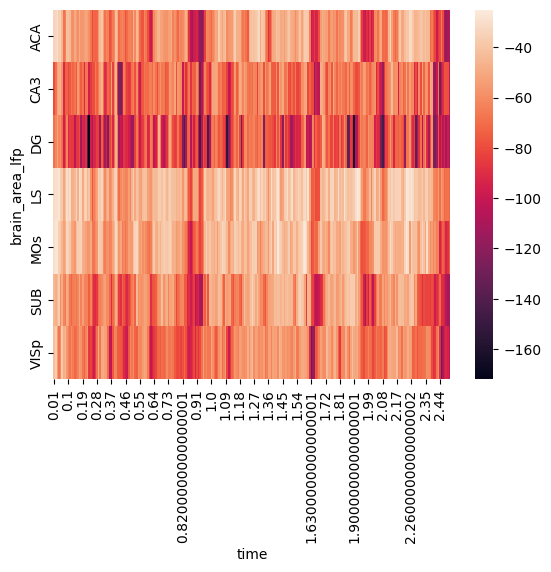

In [31]:
df = dset['lfp'].to_dataframe().reset_index()
group = df.groupby(['brain_area_lfp', 'time'])['lfp'].min().unstack()
sns.heatmap(group)

**Example** Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for feedback_type == 1

<Axes: xlabel='time', ylabel='brain_area_lfp'>

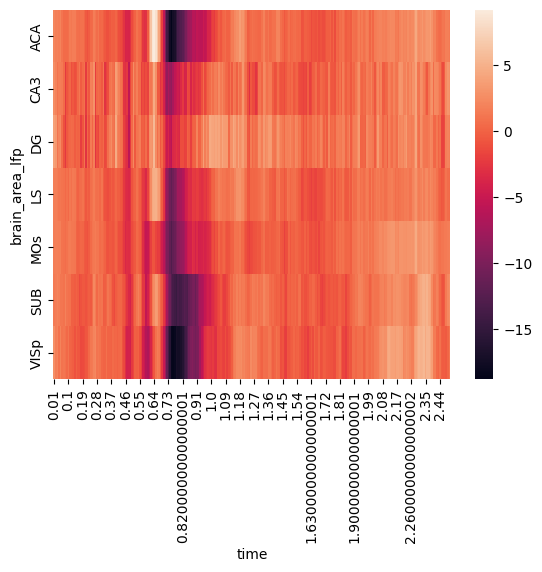

In [32]:
df = dset[['lfp', 'feedback_type']].to_dataframe().reset_index()
mask = df['feedback_type'] == 1
group = df[mask].groupby(['brain_area_lfp', 'time'])['lfp'].mean().unstack()
sns.heatmap(group)

Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for feedback_type == -1

<Axes: xlabel='time', ylabel='brain_area_lfp'>

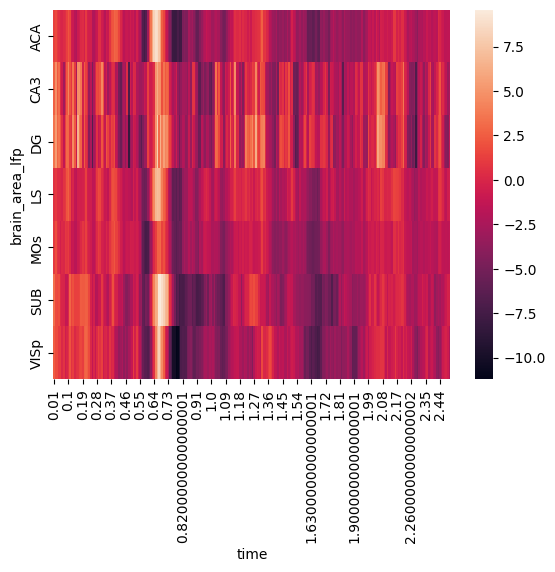

In [33]:
df = dset[['lfp', 'feedback_type']].to_dataframe().reset_index()
mask = df['feedback_type'] == -1
group = df[mask].groupby(['brain_area_lfp', 'time'])['lfp'].mean().unstack()
sns.heatmap(group)

We can get the same group with a Pandas method called pivot_table 

**Example** Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' using pivot_table

<Axes: xlabel='time', ylabel='brain_area_lfp'>

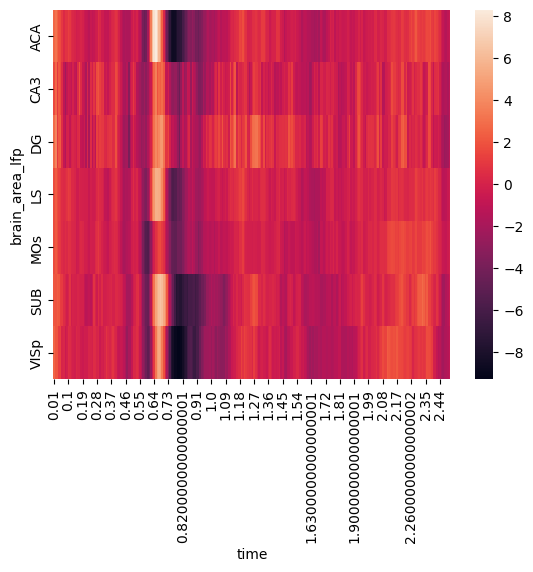

In [34]:
df = dset['lfp'].to_dataframe().reset_index()
group = df.pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='mean')
sns.heatmap(group)

Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for feedback_type == 1 using pivot table

<Axes: xlabel='time', ylabel='brain_area_lfp'>

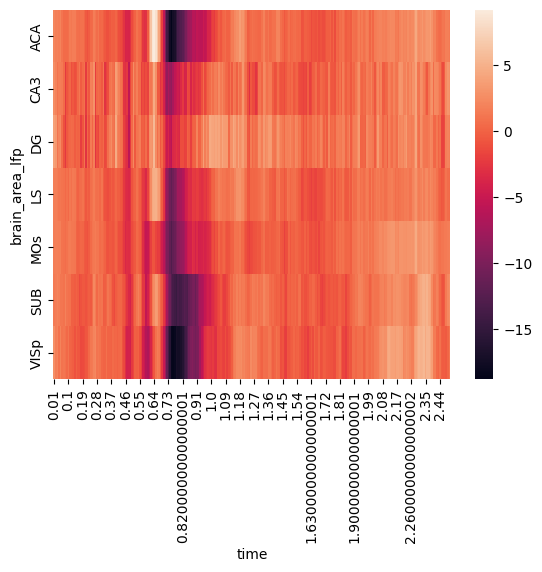

In [35]:
df = dset[['lfp', 'feedback_type']].to_dataframe().reset_index()
mask = df['feedback_type'] == 1
group = df[mask].pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='mean')
sns.heatmap(group)

Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for response_type == 1  using pivot table

<Axes: xlabel='time', ylabel='brain_area_lfp'>

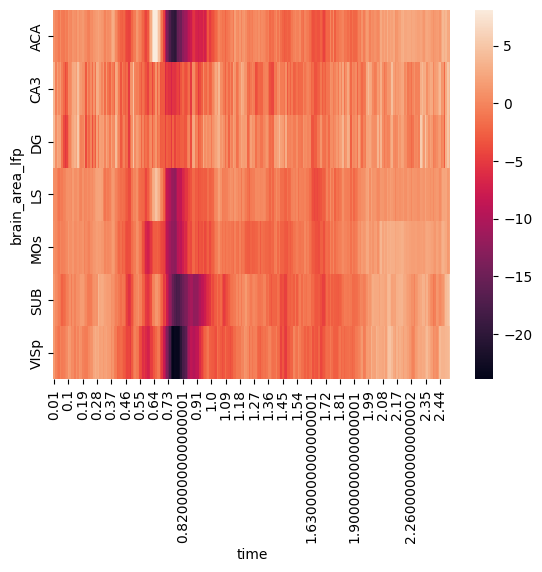

In [36]:
df = dset[['lfp', 'response_type']].to_dataframe().reset_index()
mask = df['response_type'] == 1
group = df[mask].pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='mean')
sns.heatmap(group)

Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for feedback_type == -1 using pivot_table method

<Axes: xlabel='time', ylabel='brain_area_lfp'>

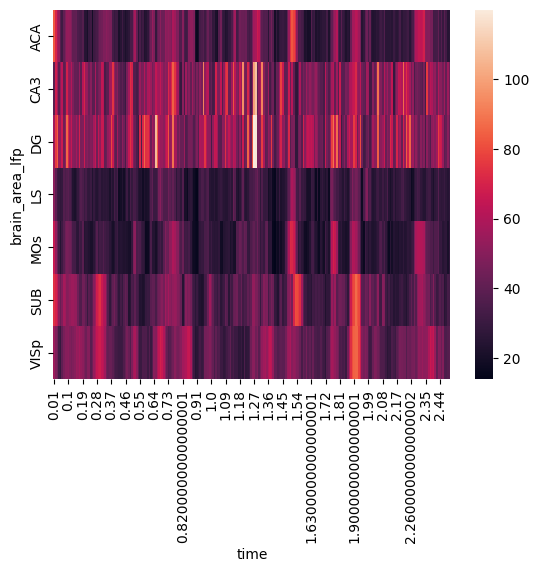

In [37]:
df = dset[['lfp', 'feedback_type']].to_dataframe().reset_index()
mask = df['feedback_type'] == -1
group = df[mask].pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='max')
sns.heatmap(group)

Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for feedback_type == 1 and response_type == 1 using pivot_table method

<Axes: xlabel='time', ylabel='brain_area_lfp'>

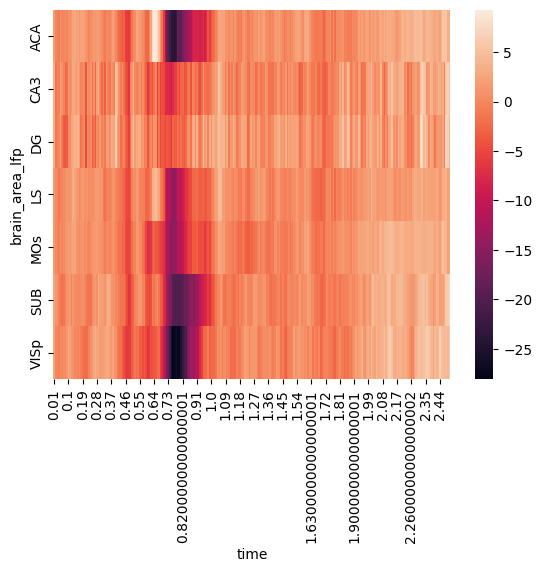

In [38]:
df = dset[['lfp', 'feedback_type', 'response_type']].to_dataframe().reset_index()
mask1 = df['response_type'] == 1
mask2 = df['feedback_type'] == 1
mask = mask1 & mask2
group = df[mask].pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='mean')
sns.heatmap(group)

Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for feedback_type == 1 and response_type == -1 using pivot_table method

<Axes: xlabel='time', ylabel='brain_area_lfp'>

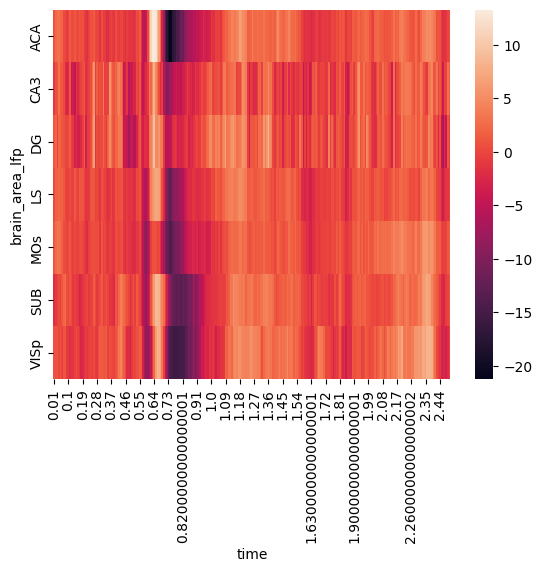

In [39]:
df = dset[['lfp', 'feedback_type', 'response_type']].to_dataframe().reset_index()
mask1 = df['response_type'] == -1
mask2 = df['feedback_type'] == 1
mask = mask1 & mask2
group = df[mask].pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='mean')
sns.heatmap(group)

Make a heatmap visualization of the mean Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for feedback_type == -1 and response_type == 0 using pivot_table method

<Axes: xlabel='time', ylabel='brain_area_lfp'>

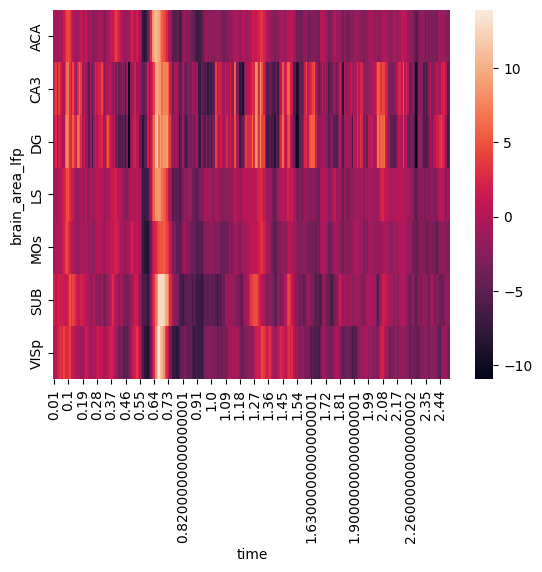

In [40]:
df = dset[['lfp', 'feedback_type', 'response_type']].to_dataframe().reset_index()
mask1 = df['response_type'] == 0
mask2 = df['feedback_type'] == -1
mask = mask1 & mask2
group = df[mask].pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='mean')
sns.heatmap(group)

Make a heatmap visualization of the median Local Field Potential (LFP) data grouped by 'brain_area_lfp' and 'time' but only for either VISp or DG brain areas using pivot_table method

<Axes: xlabel='time', ylabel='brain_area_lfp'>

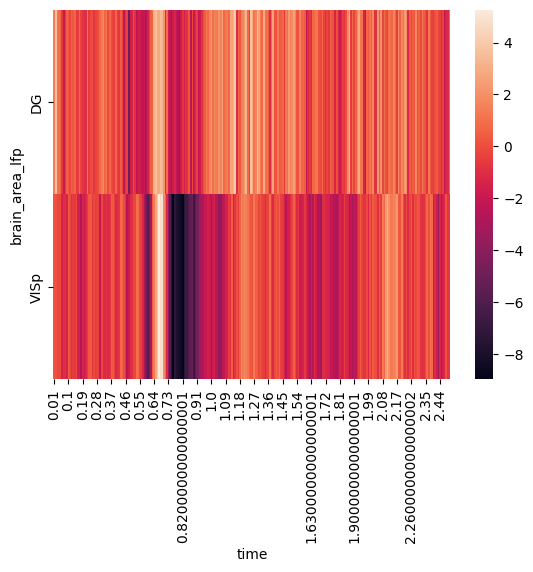

In [41]:
df = dset[['lfp']].to_dataframe().reset_index()
mask1 = df['brain_area_lfp'] == 'VISp'
mask2 = df['brain_area_lfp'] == 'DG'
mask = mask1 | mask2
group = df[mask].pivot_table(index='brain_area_lfp', columns='time', values='lfp', aggfunc='median')
sns.heatmap(group)

Extra: Play around with different combinations from the dataset and different aggfunc